In [7]:
import os
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from fastai.vision.all import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using {device} device")

Using cpu device


In [37]:
class ConvNeuralNet(nn.Module):
    def __init__(self, num_classes, use_dropout=False, use_normalization=False):
        super(ConvNeuralNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, kernel_size=5)
        self.norm1 = nn.BatchNorm2d(6) if use_normalization else None
        self.conv2 = nn.Conv2d(6, 16, kernel_size=5)
        self.norm2 = nn.BatchNorm2d(16) if use_normalization else None
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, num_classes)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5) if use_dropout else None

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        if self.norm1:
            x = self.norm1(x)
        x = self.pool(F.relu(self.conv2(x)))
        if self.norm2:
            x = self.norm2(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        if self.dropout:
            x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [38]:
# !pip install torch torchvision
# !pip install fastai

In [50]:
path = untar_data(URLs.IMAGENETTE_160)

In [210]:
def get_transforms(use_augmentation=False):
    if use_augmentation:
        return transforms.Compose([
            transforms.Resize((32, 32)),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
            transforms.ToTensor(),
        ])
    else:
        return transforms.Compose([
            transforms.Resize((32, 32)),
            transforms.ToTensor(),
        ])

In [211]:
def create_dataloader(use_augmentation=False):
    transform = get_transforms(use_augmentation)
    train_dataset = ImageFolder(root=path/'train', transform=transform)
    val_dataset = ImageFolder(root=path/'val', transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    return train_loader, val_loader

In [212]:
def train(model, train_loader, criterion, optimizer, device, num_epochs=10):
    train_losses = []
    val_losses = []
    train_accs = []
    val_accs = []
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        total = 0
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += (preds == labels).sum().item()
            total += labels.size(0)


        epoch_loss = running_loss / total
        epoch_acc = running_corrects / total
        train_losses.append(epoch_loss)
        train_accs.append(epoch_acc)
        
        # Validation loop
        model.eval()
        val_loss = 0.0
        val_corrects = 0
        val_total = 0
        all_labels = []
        all_preds = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                
                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                val_corrects += (preds == labels).sum().item()
                val_total += labels.size(0)
                
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
        
        val_loss_epoch = val_loss / val_total
        val_acc_epoch = val_corrects / val_total
        
        val_losses.append(val_loss_epoch)
        val_accs.append(val_acc_epoch)

        scheduler.step()

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Training Loss: {epoch_loss:.4f}, Training Accuracy: {epoch_acc:.4f}, '
              f'Validation Loss: {val_loss_epoch:.4f}, Validation Accuracy: {val_acc_epoch:.4f}')
    
    return train_losses, val_losses, train_accs, val_accs, all_labels, all_preds

In [79]:
# def evaluate(model, val_loader, device):
#     model.eval()
#     val_loss, val_acc = [], []
#     all_labels = []
#     all_preds = []

#     with torch.no_grad():
#         for images, labels in val_loader:
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             val_loss.append(loss.item())

#             _, predicted = torch.max(outputs.data, 1)
#             all_labels.extend(labels.cpu().numpy())
#             all_preds.extend(predicted.cpu().numpy())

#     val_acc = np.mean(np.array(all_labels) == np.array(all_preds))
#     print(f'Validation Loss: {np.mean(val_loss):.4f}, Validation Accuracy: {val_acc:.4f}')
    
#     return val_loss, val_acc, all_labels, all_preds

In [213]:
def plot_curves(train_losses, val_losses, train_accs, val_accs, title):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b', label='Training loss')
    plt.plot(epochs, val_losses, 'r', label='Validation loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, 'b', label='Training accuracy')
    plt.plot(epochs, val_accs, 'r', label='Validation accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

In [214]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_true, y_pred, num_classes):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(num_classes))
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

In [215]:
# Experiment configurations
num_classes = 10
num_epochs = 25
# Experiment 1: Without normalization and dropout, without data augmentation
train_loader, val_loader = create_dataloader(use_augmentation=False)
model_no_norm_no_dropout = ConvNeuralNet(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_no_norm_no_dropout.parameters(), lr=0.001)

# Train your model without batch normalization applied after the convolution layers

In [216]:
train_losses, val_losses, train_accs, val_accs, all_labels, all_preds = train(model_no_norm_no_dropout, train_loader, criterion, optimizer, device, num_epochs)

Epoch [1/25], Training Loss: 2.0940, Training Accuracy: 0.2384, Validation Loss: 1.9916, Validation Accuracy: 0.2772
Epoch [2/25], Training Loss: 1.8929, Training Accuracy: 0.3375, Validation Loss: 1.8684, Validation Accuracy: 0.3297
Epoch [3/25], Training Loss: 1.8178, Training Accuracy: 0.3652, Validation Loss: 1.7789, Validation Accuracy: 0.3732
Epoch [4/25], Training Loss: 1.7490, Training Accuracy: 0.3871, Validation Loss: 1.7404, Validation Accuracy: 0.4038
Epoch [5/25], Training Loss: 1.6758, Training Accuracy: 0.4242, Validation Loss: 1.6859, Validation Accuracy: 0.4166
Epoch [6/25], Training Loss: 1.6007, Training Accuracy: 0.4519, Validation Loss: 1.6840, Validation Accuracy: 0.4308
Epoch [7/25], Training Loss: 1.5457, Training Accuracy: 0.4727, Validation Loss: 1.6325, Validation Accuracy: 0.4474
Epoch [8/25], Training Loss: 1.4941, Training Accuracy: 0.4919, Validation Loss: 1.6102, Validation Accuracy: 0.4561
Epoch [9/25], Training Loss: 1.4482, Training Accuracy: 0.5083, 

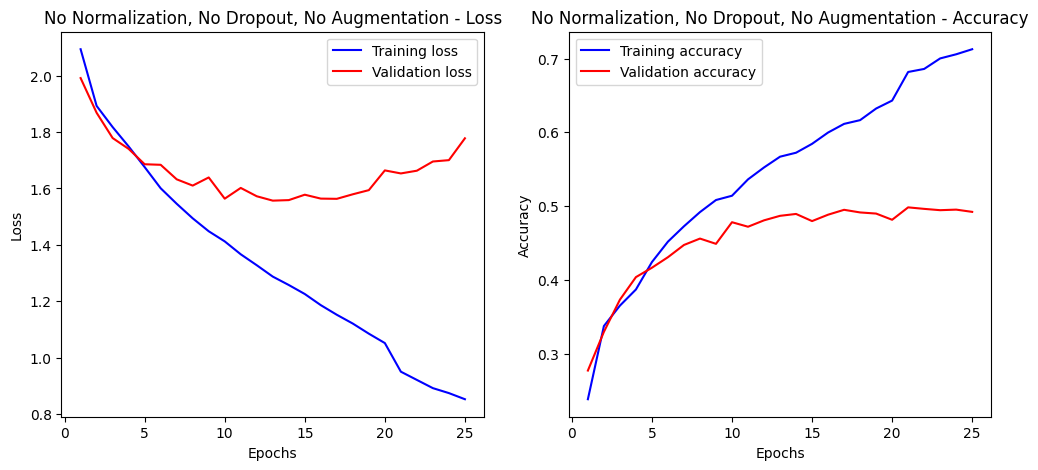

In [217]:
plot_curves(train_losses, val_losses, train_accs, val_accs, 'No Normalization, No Dropout, No Augmentation')

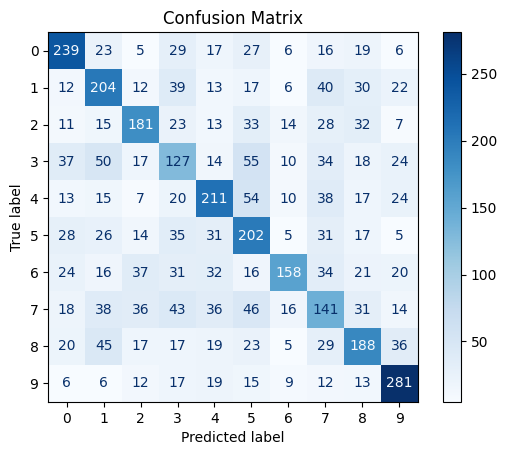

In [218]:
plot_confusion_matrix(all_labels, all_preds, num_classes)

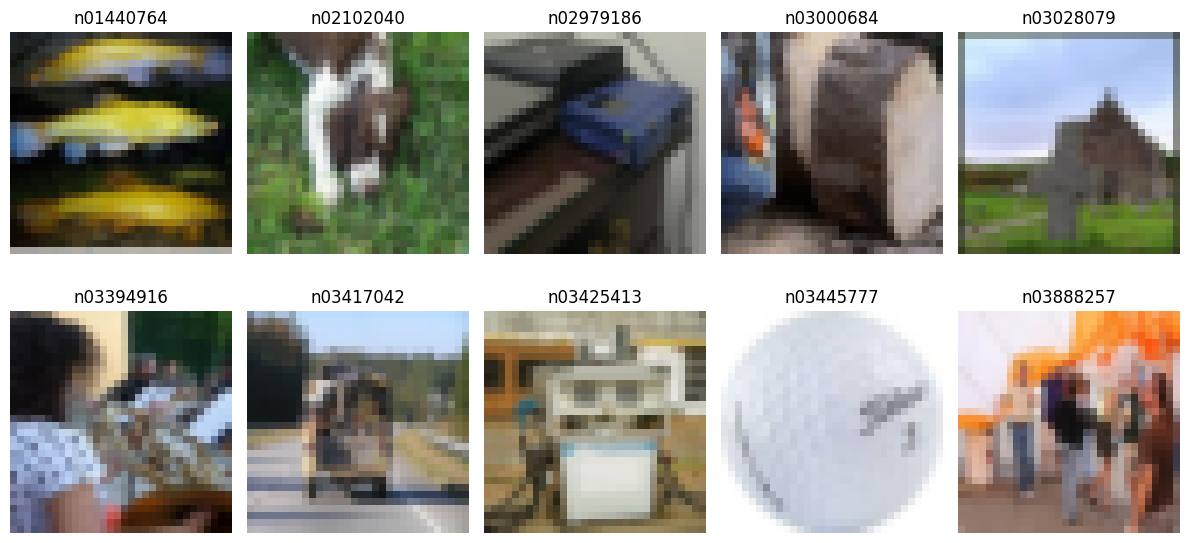

In [219]:
class_names = train_dataset.classes

images_per_class = {class_name: None for class_name in class_names}

for images, labels in train_loader:
    for img, label in zip(images, labels):
        class_name = class_names[label.item()]
        if images_per_class[class_name] is None:
            images_per_class[class_name] = img
    if all(images_per_class[class_name] is not None for class_name in class_names):
        break

plt.figure(figsize=(12, 6))
for i, (class_name, img_tensor) in enumerate(images_per_class.items()):
    plt.subplot(2, 5, i + 1)  
    if img_tensor is not None:
        plt.imshow(img_tensor.permute(1, 2, 0))
        plt.title(class_name)
    plt.axis('off')
plt.tight_layout()
plt.show()

# Train your model with batch normalization applied after the convolution layers

In [220]:
num_classes = 10
num_epochs = 20

# Experiment 1: With normalization and without data augmentation and dropout
train_loader, val_loader = create_dataloader(use_augmentation=False)
model_norm_no_dropout = ConvNeuralNet(num_classes, False, True).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_norm_no_dropout.parameters(), lr=0.001)

In [221]:
train_losses, val_losses, train_accs, val_accs, all_labels, all_preds = train(model_norm_no_dropout, train_loader, criterion, optimizer, device, num_epochs)

Epoch [1/20], Training Loss: 1.7718, Training Accuracy: 0.3856, Validation Loss: 1.5736, Validation Accuracy: 0.4599
Epoch [2/20], Training Loss: 1.4624, Training Accuracy: 0.5058, Validation Loss: 1.7166, Validation Accuracy: 0.4290
Epoch [3/20], Training Loss: 1.3266, Training Accuracy: 0.5481, Validation Loss: 1.4947, Validation Accuracy: 0.5029
Epoch [4/20], Training Loss: 1.2241, Training Accuracy: 0.5858, Validation Loss: 1.5245, Validation Accuracy: 0.4978
Epoch [5/20], Training Loss: 1.1392, Training Accuracy: 0.6171, Validation Loss: 1.4311, Validation Accuracy: 0.5330
Epoch [6/20], Training Loss: 1.0383, Training Accuracy: 0.6537, Validation Loss: 1.4383, Validation Accuracy: 0.5373
Epoch [7/20], Training Loss: 0.9579, Training Accuracy: 0.6763, Validation Loss: 1.4968, Validation Accuracy: 0.5340
Epoch [8/20], Training Loss: 0.8701, Training Accuracy: 0.7057, Validation Loss: 1.4939, Validation Accuracy: 0.5468
Epoch [9/20], Training Loss: 0.7930, Training Accuracy: 0.7314, 

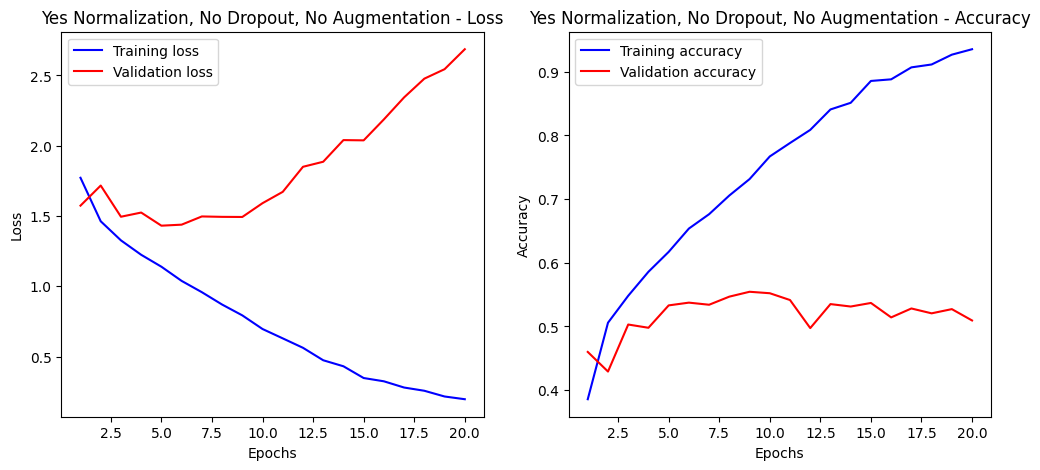

In [222]:
plot_curves(train_losses, val_losses, train_accs, val_accs, 'Yes Normalization, No Dropout, No Augmentation')

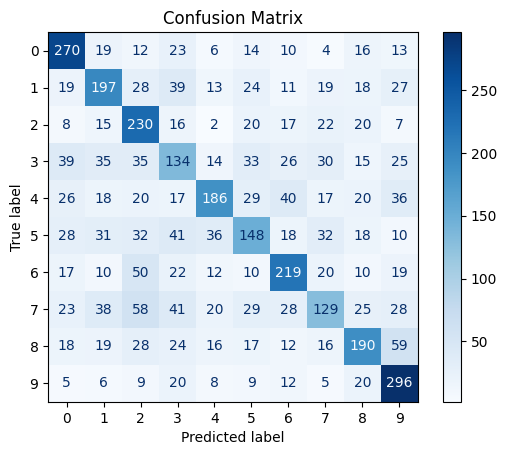

In [223]:
plot_confusion_matrix(all_labels, all_preds, num_classes)

# Train your model with Dropout regularization applied after the convolution layers

In [224]:
num_classes = 10
num_epochs = 20

# Experiment 1: With normalization and without data augmentation and dropout
train_loader, val_loader = create_dataloader(use_augmentation=True)
model_augmentation = ConvNeuralNet(num_classes, False, False).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_augmentation.parameters(), lr=0.001)

In [225]:
train_losses, val_losses, train_accs, val_accs, all_labels, all_preds = train(model_augmentation, train_loader, criterion, optimizer, device, num_epochs)

Epoch [1/20], Training Loss: 2.1007, Training Accuracy: 0.2359, Validation Loss: 1.9418, Validation Accuracy: 0.3116
Epoch [2/20], Training Loss: 1.8830, Training Accuracy: 0.3382, Validation Loss: 1.8414, Validation Accuracy: 0.3646
Epoch [3/20], Training Loss: 1.7711, Training Accuracy: 0.3904, Validation Loss: 1.7200, Validation Accuracy: 0.4176
Epoch [4/20], Training Loss: 1.6782, Training Accuracy: 0.4285, Validation Loss: 1.6798, Validation Accuracy: 0.4324
Epoch [5/20], Training Loss: 1.6092, Training Accuracy: 0.4519, Validation Loss: 1.6380, Validation Accuracy: 0.4436
Epoch [6/20], Training Loss: 1.5675, Training Accuracy: 0.4717, Validation Loss: 1.5965, Validation Accuracy: 0.4683
Epoch [7/20], Training Loss: 1.5303, Training Accuracy: 0.4912, Validation Loss: 1.6165, Validation Accuracy: 0.4619
Epoch [8/20], Training Loss: 1.4848, Training Accuracy: 0.5035, Validation Loss: 1.5558, Validation Accuracy: 0.4836
Epoch [9/20], Training Loss: 1.4498, Training Accuracy: 0.5144, 

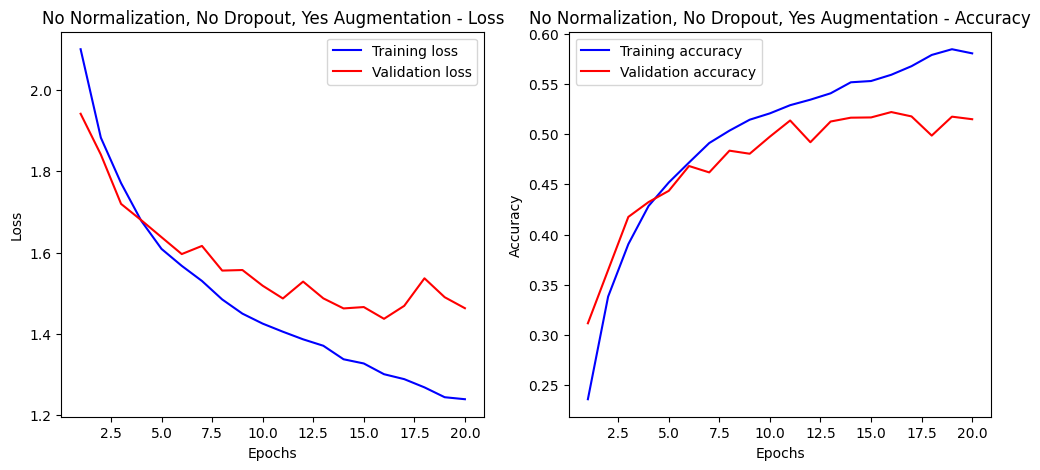

In [226]:
plot_curves(train_losses, val_losses, train_accs, val_accs, 'No Normalization, No Dropout, Yes Augmentation')

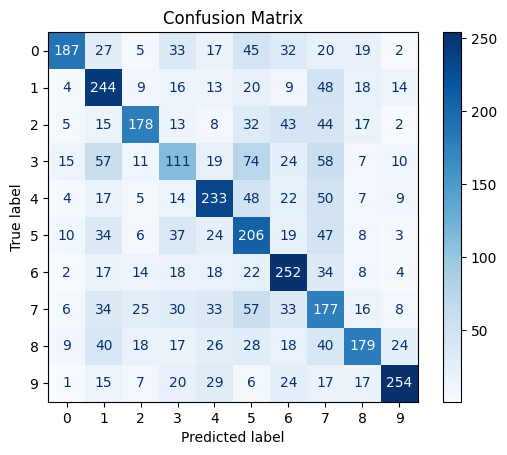

In [227]:
plot_confusion_matrix(all_labels, all_preds, num_classes)

In [242]:
num_classes = 10
num_epochs = 20

# Experiment 1: With normalization and without data augmentation and dropout
train_loader, val_loader = create_dataloader(use_augmentation=False)
model_dropout = ConvNeuralNet(num_classes, True, False).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_dropout.parameters(), lr=0.001)

In [243]:
train_losses, val_losses, train_accs, val_accs, all_labels, all_preds = train(model_dropout, train_loader, criterion, optimizer, device, num_epochs)

Epoch [1/20], Training Loss: 2.1213, Training Accuracy: 0.2252, Validation Loss: 2.0415, Validation Accuracy: 0.2729
Epoch [2/20], Training Loss: 1.9658, Training Accuracy: 0.3030, Validation Loss: 1.9064, Validation Accuracy: 0.3355
Epoch [3/20], Training Loss: 1.8911, Training Accuracy: 0.3464, Validation Loss: 1.8365, Validation Accuracy: 0.3587
Epoch [4/20], Training Loss: 1.8090, Training Accuracy: 0.3808, Validation Loss: 1.7521, Validation Accuracy: 0.4015
Epoch [5/20], Training Loss: 1.7433, Training Accuracy: 0.4051, Validation Loss: 1.6885, Validation Accuracy: 0.4359
Epoch [6/20], Training Loss: 1.7007, Training Accuracy: 0.4188, Validation Loss: 1.6683, Validation Accuracy: 0.4382
Epoch [7/20], Training Loss: 1.6695, Training Accuracy: 0.4372, Validation Loss: 1.6430, Validation Accuracy: 0.4515
Epoch [8/20], Training Loss: 1.6305, Training Accuracy: 0.4465, Validation Loss: 1.6439, Validation Accuracy: 0.4466
Epoch [9/20], Training Loss: 1.6058, Training Accuracy: 0.4581, 

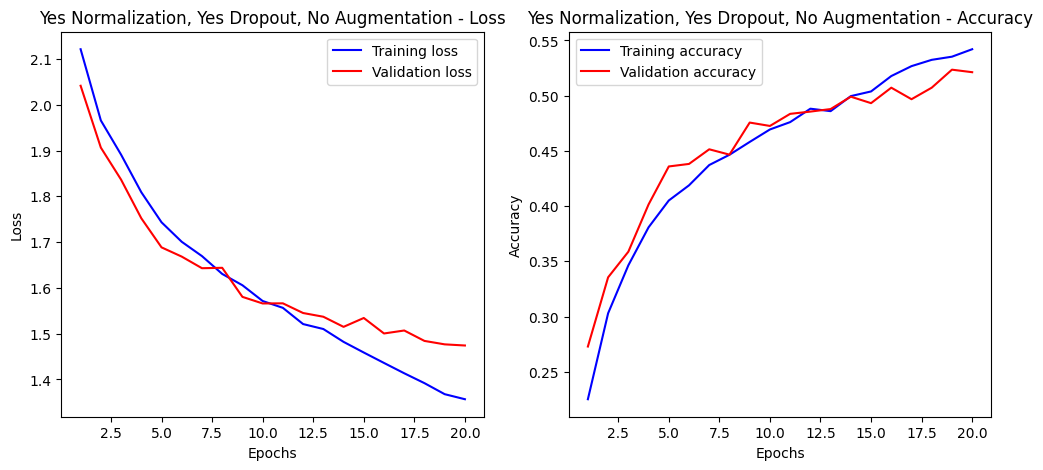

In [244]:
plot_curves(train_losses, val_losses, train_accs, val_accs, 'Yes Normalization, Yes Dropout, No Augmentation')

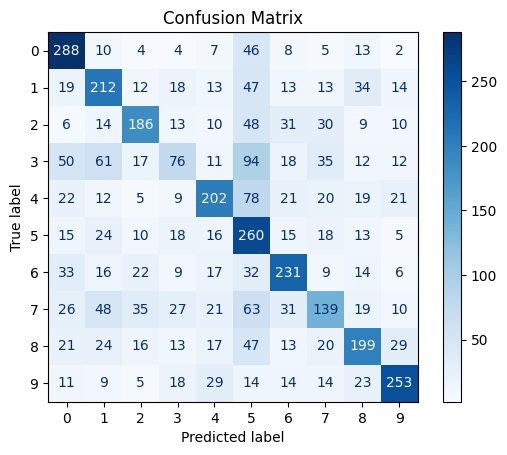

In [245]:
plot_confusion_matrix(all_labels, all_preds, num_classes)

# Final

In [232]:
num_classes = 10
num_epochs = 45

# Experiment 1: With normalization and without data augmentation and dropout
train_loader, val_loader = create_dataloader(use_augmentation=True)
model_final = ConvNeuralNet(num_classes, True, True).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_final.parameters(), lr=0.001)

In [233]:
train_losses, val_losses, train_accs, val_accs, all_labels, all_preds = train(model_final, train_loader, criterion, optimizer, device, num_epochs)

Epoch [1/45], Training Loss: 1.9691, Training Accuracy: 0.3132, Validation Loss: 1.8131, Validation Accuracy: 0.3750
Epoch [2/45], Training Loss: 1.7511, Training Accuracy: 0.4009, Validation Loss: 1.7233, Validation Accuracy: 0.4171
Epoch [3/45], Training Loss: 1.6404, Training Accuracy: 0.4420, Validation Loss: 1.6426, Validation Accuracy: 0.4438
Epoch [4/45], Training Loss: 1.5556, Training Accuracy: 0.4738, Validation Loss: 1.8527, Validation Accuracy: 0.3814
Epoch [5/45], Training Loss: 1.4957, Training Accuracy: 0.4966, Validation Loss: 1.4923, Validation Accuracy: 0.5034
Epoch [6/45], Training Loss: 1.4559, Training Accuracy: 0.5180, Validation Loss: 1.7941, Validation Accuracy: 0.4306
Epoch [7/45], Training Loss: 1.4302, Training Accuracy: 0.5229, Validation Loss: 1.5027, Validation Accuracy: 0.4994
Epoch [8/45], Training Loss: 1.3747, Training Accuracy: 0.5484, Validation Loss: 1.4191, Validation Accuracy: 0.5228
Epoch [9/45], Training Loss: 1.3619, Training Accuracy: 0.5436, 

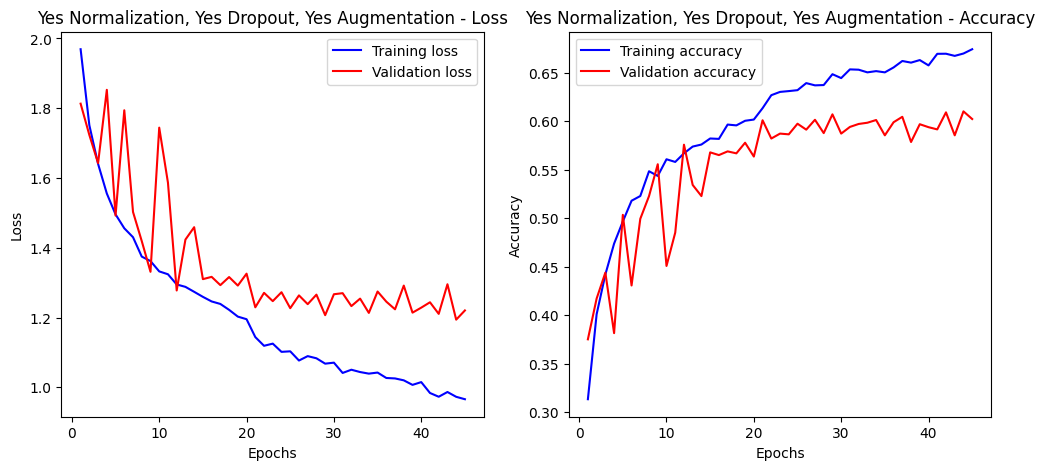

In [234]:
plot_curves(train_losses, val_losses, train_accs, val_accs, 'Yes Normalization, Yes Dropout, Yes Augmentation')

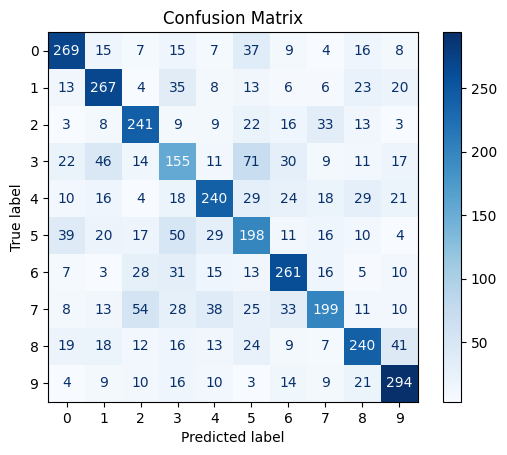

In [235]:
plot_confusion_matrix(all_labels, all_preds, num_classes)